In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetise/tensorflow.csv
/kaggle/input/datasetise/incubator-mxnet.csv
/kaggle/input/datasetise/keras.csv
/kaggle/input/datasetise/caffe.csv
/kaggle/input/datasetise/pytorch.csv
/kaggle/input/caffeset/caffe.csv


In [32]:
########## 1. Import required libraries ##########

import pandas as pd
import numpy as np
import re
import math

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc)

# Classifier
from sklearn.naive_bayes import GaussianNB

# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

########## 2. Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Stopwords
NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']  # You can customize this list as needed
final_stop_words_list = NLTK_stop_words_list + custom_stop_words_list

def remove_stopwords(text):
    """Remove stopwords from the text."""
    return " ".join([word for word in str(text).split() if word not in final_stop_words_list])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

########## 3. Download & read data ##########
import os
import subprocess
# Choose the project (options: 'pytorch', 'tensorflow', 'keras', 'incubator-mxnet', 'caffe')
project = '/kaggle/input/caffeset/caffe'
path = f'{project}.csv'

pd_all = pd.read_csv(path)
pd_all = pd_all.sample(frac=1, random_state=999)  # Shuffle

# Merge Title and Body into a single column; if Body is NaN, use Title only
pd_all['Title+Body'] = pd_all.apply(
    lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
    axis=1
)

# Keep only necessary columns: id, Number, sentiment, text (merged Title+Body)
pd_tplusb = pd_all.rename(columns={
    "Unnamed: 0": "id",
    "class": "sentiment",
    "Title+Body": "text"
})
pd_tplusb.to_csv('Title+Body.csv', index=False, columns=["id", "Number", "sentiment", "text"])

########## 4. Configure parameters & Start training ##########

# ========== Key Configurations ==========

# 1) Data file to read
datafile = '/kaggle/working/Title+Body.csv'

# 2) Number of repeated experiments
REPEAT = 10

# 3) Output CSV file name
out_csv_name = f'../{project}_NB.csv'

# ========== Read and clean data ==========
data = pd.read_csv(datafile).fillna('')
text_col = 'text'

# Keep a copy for referencing original data if needed
original_data = data.copy()

# Text cleaning
data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

# ========== Hyperparameter grid ==========
# We use logspace for var_smoothing: [1e-12, 1e-11, ..., 1]
params = {
    'var_smoothing': np.logspace(-12, 0, 13)
}

# Lists to store metrics across repeated runs
accuracies  = []
precisions  = []
recalls     = []
f1_scores   = []
auc_values  = []

for repeated_time in range(REPEAT):
    # --- 4.1 Split into train/test ---
    indices = np.arange(data.shape[0])
    train_index, test_index = train_test_split(
        indices, test_size=0.2, random_state=repeated_time
    )

    train_text = data[text_col].iloc[train_index]
    test_text = data[text_col].iloc[test_index]
    
    y_train = data['sentiment'].iloc[train_index]
    y_test = data['sentiment'].iloc[test_index]
    
    # --- 4.2 TF-IDF vectorization ---
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=1000  # Adjust as needed
    )
    X_train = tfidf.fit_transform(train_text).toarray()  # Convert to dense matrix
    X_test = tfidf.transform(test_text).toarray()       # Convert to dense matrix
    
    # --- 4.3 Naive Bayes model & GridSearch ---
    clf = GaussianNB()
    grid = GridSearchCV(
        clf,
        params,
        cv=5,              # 5-fold CV (can be changed)
        scoring='roc_auc'  # Using roc_auc as the metric for selection
    )
    grid.fit(X_train, y_train)


    # Retrieve the best model
    best_clf = grid.best_estimator_
    best_clf.fit(X_train, y_train)

    # --- 4.4 Make predictions & evaluate ---
    y_pred = best_clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Precision (macro)
    prec = precision_score(y_test, y_pred, average='macro')
    precisions.append(prec)

    # Recall (macro)
    rec = recall_score(y_test, y_pred, average='macro')
    recalls.append(rec)

    # F1 Score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1)

    # AUC
    # If labels are 0/1 only, this works directly.
    # If labels are something else, adjust pos_label accordingly.
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)
    auc_values.append(auc_val)

# --- 4.5 Aggregate results ---
final_accuracy  = np.mean(accuracies)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_auc       = np.mean(auc_values)

print("=== Naive Bayes + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")

# Save final results to CSV (append mode)
try:
    # Attempt to check if the file already has a header
    existing_data = pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log = pd.DataFrame(
    {
        'repeated_times': [REPEAT],
        'Accuracy': [final_accuracy],
        'Precision': [final_precision],
        'Recall': [final_recall],
        'F1': [final_f1],
        'AUC': [final_auc],
        'CV_list(AUC)': [str(auc_values)]
    }
)

out_csv_name = '/kaggle/working/caffe_results.csv'  # Save in /kaggle/working directory
df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
=== Naive Bayes + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.5224
Average Precision:     0.5571
Average Recall:        0.6234
Average F1 score:      0.4428
Average AUC:           0.6234

Results have been saved to: /kaggle/working/caffe_results.csv


In [33]:
########## Import required libraries ##########

import pandas as pd
import numpy as np
import re
import math

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc)

# Classifier
from sklearn.naive_bayes import MultinomialNB  # Import Multinomial Naive Bayes

# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

########## Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Stopwords
NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']  # You can customize this list as needed
final_stop_words_list = NLTK_stop_words_list + custom_stop_words_list

def remove_stopwords(text):
    """Remove stopwords from the text."""
    return " ".join([word for word in str(text).split() if word not in final_stop_words_list])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

########## Download & read data ##########
import os
import subprocess
# Choose the project (options: 'pytorch', 'tensorflow', 'keras', 'incubator-mxnet', 'caffe')
project = '/kaggle/input/caffeset/caffe'
path = f'{project}.csv'

pd_all = pd.read_csv(path)
pd_all = pd_all.sample(frac=1, random_state=999)  # Shuffle

# Merge Title and Body into a single column; if Body is NaN, use Title only
pd_all['Title+Body'] = pd_all.apply(
    lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
    axis=1
)

# Keep only necessary columns: id, Number, sentiment, text (merged Title+Body)
pd_tplusb = pd_all.rename(columns={
    "Unnamed: 0": "id",
    "class": "sentiment",
    "Title+Body": "text"
})
pd_tplusb.to_csv('Title+Body.csv', index=False, columns=["id", "Number", "sentiment", "text"])

########## Configure parameters & Start training ##########

# ========== Key Configurations ==========

# 1) Data file to read
datafile = '/kaggle/working/Title+Body.csv'

# 2) Number of repeated experiments
REPEAT = 10

# 3) Output CSV file name
out_csv_name = f'../{project}_NB.csv'

# ========== Read and clean data ==========
data = pd.read_csv(datafile).fillna('')
text_col = 'text'

# Keep a copy for referencing original data if needed
original_data = data.copy()

# Text cleaning
data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

# ========== Hyperparameter grid ==========
# Parameters for Multinomial Naive Bayes
params = {
    'alpha': np.linspace(0.1, 1.0, 10)  # Smoothing parameter
}

# Lists to store metrics across repeated runs
accuracies  = []
precisions  = []
recalls     = []
f1_scores   = []
auc_values  = []

for repeated_time in range(REPEAT):
    # --- 4.1 Split into train/test ---
    indices = np.arange(data.shape[0])
    train_index, test_index = train_test_split(
        indices, test_size=0.2, random_state=repeated_time
    )

    train_text = data[text_col].iloc[train_index]
    test_text = data[text_col].iloc[test_index]
    
    y_train = data['sentiment'].iloc[train_index]
    y_test = data['sentiment'].iloc[test_index]
    
    # --- 4.2 TF-IDF vectorization ---
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=1000  # Adjust as needed
    )
    X_train = tfidf.fit_transform(train_text).toarray()  # Convert to dense matrix
    X_test = tfidf.transform(test_text).toarray()       # Convert to dense matrix
    
    # --- 4.3 Multinomial Naive Bayes model & GridSearch ---
    clf = MultinomialNB()
    grid = GridSearchCV(
        clf,
        params,
        cv=5,              # 5-fold CV (can be changed)
        scoring='roc_auc'  # Using roc_auc as the metric for selection
    )
    grid.fit(X_train, y_train)


    # Retrieve the best model
    best_clf = grid.best_estimator_
    best_clf.fit(X_train, y_train)

    # --- 4.4 Make predictions & evaluate ---
    y_pred = best_clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Precision (macro)
    prec = precision_score(y_test, y_pred, average='macro')
    precisions.append(prec)

    # Recall (macro)
    rec = recall_score(y_test, y_pred, average='macro')
    recalls.append(rec)

    # F1 Score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1)

    # AUC
    # If labels are 0/1 only, this works directly.
    # If labels are something else, adjust pos_label accordingly.
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)
    auc_values.append(auc_val)

# --- 4.5 Aggregate results ---
final_accuracy  = np.mean(accuracies)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_auc       = np.mean(auc_values)

print("=== Multinomial Naive Bayes + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")

# Save final results to CSV (append mode)
try:
    # Attempt to check if the file already has a header
    existing_data = pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log = pd.DataFrame(
    {
        'repeated_times': [REPEAT],
        'Accuracy': [final_accuracy],
        'Precision': [final_precision],
        'Recall': [final_recall],
        'F1': [final_f1],
        'AUC': [final_auc],
        'CV_list(AUC)': [str(auc_values)]
    }
)

out_csv_name = '/kaggle/working/caffe_resultsMN.csv'  # Save in /kaggle/working directory

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=== Multinomial Naive Bayes + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.8983
Average Precision:     0.6609
Average Recall:        0.5552
Average F1 score:      0.5612
Average AUC:           0.5552

Results have been saved to: /kaggle/working/caffe_resultsMN.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing dataset: /kaggle/input/datasetise/tensorflow.csv
Processing dataset: /kaggle/input/datasetise/incubator-mxnet.csv
Processing dataset: /kaggle/input/datasetise/keras.csv
Processing dataset: /kaggle/input/datasetise/caffe.csv
Processing dataset: /kaggle/input/datasetise/pytorch.csv
=== Average Metrics Across All Datasets ===
                 Accuracy  Precision   Recall        F1       AUC
Average Metrics  0.585715   0.614009  0.72041  0.536148  0.827789


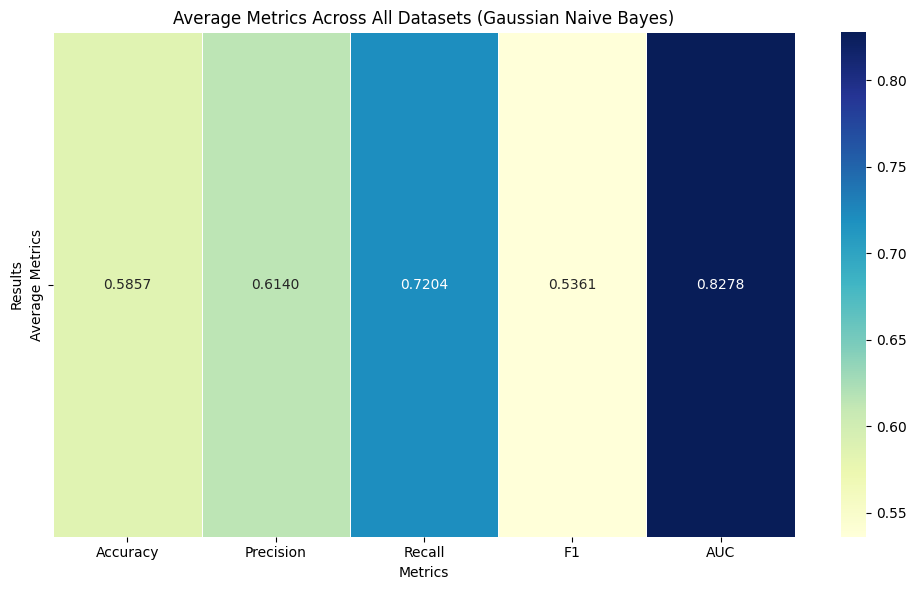

In [34]:
########## 1. Import required libraries ##########

import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

########## 2. Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']  # Customize stopwords if needed
final_stop_words_list = NLTK_stop_words_list + custom_stop_words_list

def remove_stopwords(text):
    """Remove stopwords from the text."""
    return " ".join([word for word in str(text).split() if word.lower() not in final_stop_words_list])

def clean_str(string):
    """Clean text by removing non-alphanumeric characters and converting to lowercase."""
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

########## 3. Process a single dataset ##########

def process_dataset(datafile, params, model, REPEAT=10):
    """Process one dataset, train the model, and return metrics."""
    data = pd.read_csv(datafile).fillna('')  # Load dataset and fill missing values
    
    # Combine 'Title' and 'Body' 
    if 'Title' in data.columns and 'Body' in data.columns:
        data['text'] = data.apply(lambda row: row['Title'] + ' ' + row['Body'], axis=1)
    elif 'Title' in data.columns:
        data['text'] = data['Title']
    else:
        raise KeyError(f"The dataset {datafile} is missing required columns.")

    # Preprocess text
    data['text'] = data['text'].apply(remove_html).apply(remove_emoji).apply(remove_stopwords).apply(clean_str)

    # Detect and handle target column
    target_column = None
    for col in ['sentiment', 'class', 'label', 'target']:
        if col in data.columns:
            target_column = col
            break
    if target_column is None:
        raise KeyError(f"No valid target column found in the dataset {datafile}.")

    # Lists to store metrics across multiple runs
    accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []

    for repeated_time in range(REPEAT):
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            data['text'], data[target_column], test_size=0.2, random_state=repeated_time
        )

        # TF-IDF vectorization
        tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
        X_train_tfidf = tfidf.fit_transform(X_train).toarray()
        X_test_tfidf = tfidf.transform(X_test).toarray()

        # Model hyperparameter tuning with GridSearchCV
        grid = GridSearchCV(model, params, cv=5, scoring='roc_auc')
        grid.fit(X_train_tfidf, y_train)
        best_clf = grid.best_estimator_

        # Train and evaluate the model
        best_clf.fit(X_train_tfidf, y_train)
        y_pred = best_clf.predict(X_test_tfidf)

        # Calculate metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        if hasattr(best_clf, "predict_proba"):
            auc_values.append(auc(*roc_curve(y_test, best_clf.predict_proba(X_test_tfidf)[:, 1])[:2]))
        else:
            auc_values.append(np.nan)

    return [
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(f1_scores),
        np.nanmean(auc_values)
    ]

########## 4. Dynamically Load Datasets ##########

dataset_directory = '/kaggle/input/datasetise/'
datasets = [os.path.join(dataset_directory, file) for file in os.listdir(dataset_directory) if file.endswith('.csv')]

# Model and hyperparameter configuration
params = {'var_smoothing': np.logspace(-12, 0, 13)}
model = GaussianNB()

# Collect metrics for each dataset
all_metrics = []
for dataset_path in datasets:
    print(f"Processing dataset: {dataset_path}")
    metrics = process_dataset(dataset_path, params, model)
    all_metrics.append(metrics)

# Calculate average metrics across all datasets
average_metrics_gaussian = np.mean(all_metrics, axis=0)
metrics_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
average_metrics_df = pd.DataFrame([average_metrics_gaussian], columns=metrics_names, index=["Average Metrics"])

########## 5. Output Results ##########

print("=== Average Metrics Across All Datasets ===")
print(average_metrics_df)

########## 6. Visualization ##########

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(
    average_metrics_df,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    linewidths=0.5
)
plt.title("Average Metrics Across All Datasets (Gaussian Naive Bayes)")
plt.xlabel("Metrics")
plt.ylabel("Results")
plt.tight_layout()
plt.show()


In [35]:
########## Import required libraries ##########

import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

########## Preprocessing Methods ##########

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

NLTK_stop_words_list = stopwords.words('english')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word.lower() not in NLTK_stop_words_list])

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

########## Function to Process Dataset ##########

def process_dataset_decision_tree(datafile, params, REPEAT=10):
    data = pd.read_csv(datafile).fillna('')
    if 'Title' in data.columns and 'Body' in data.columns:
        data['text'] = data['Title'] + ' ' + data['Body']
    elif 'Title' in data.columns:
        data['text'] = data['Title']
    else:
        raise KeyError(f"The dataset {datafile} is missing required columns.")

    data['text'] = data['text'].apply(remove_html).apply(remove_emoji).apply(remove_stopwords).apply(clean_str)

    target_column = None
    for col in ['sentiment', 'class', 'label', 'target']:
        if col in data.columns:
            target_column = col
            break
    if target_column is None:
        raise KeyError(f"No valid target column found in {datafile}.")

    accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []
    for repeated_time in range(REPEAT):
        X_train, X_test, y_train, y_test = train_test_split(data['text'], data[target_column], test_size=0.2, random_state=repeated_time)
        tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
        X_train_tfidf = tfidf.fit_transform(X_train).toarray()
        X_test_tfidf = tfidf.transform(X_test).toarray()

        grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, scoring='roc_auc')
        grid.fit(X_train_tfidf, y_train)
        best_clf = grid.best_estimator_

        best_clf.fit(X_train_tfidf, y_train)
        y_pred = best_clf.predict(X_test_tfidf)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        auc_values.append(auc(*roc_curve(y_test, best_clf.predict_proba(X_test_tfidf)[:, 1])[:2]))

    return [np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1_scores), np.mean(auc_values)]

########## Load Datasets and Process ##########

dataset_directory = '/kaggle/input/datasetise/'
datasets = [os.path.join(dataset_directory, file) for file in os.listdir(dataset_directory) if file.endswith('.csv')]
params_dt = {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]}

all_metrics_decision_tree = []
for dataset_path in datasets:
    metrics = process_dataset_decision_tree(dataset_path, params_dt)
    all_metrics_decision_tree.append(metrics)

average_metrics_decision_tree = np.mean(all_metrics_decision_tree, axis=0)
print("=== Average Metrics for Decision Tree ===")
print(pd.DataFrame([average_metrics_decision_tree], columns=["Accuracy", "Precision", "Recall", "F1", "AUC"], index=["Decision Tree"]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
=== Average Metrics for Decision Tree ===
               Accuracy  Precision    Recall        F1       AUC
Decision Tree  0.857275   0.714861  0.700733  0.699577  0.722226


In [36]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Preprocessing methods remain the same
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

NLTK_stop_words_list = stopwords.words('english')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word.lower() not in NLTK_stop_words_list])

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def process_dataset_multinomial(datafile, params, REPEAT=10):
    """Process one dataset, train the Multinomial Naive Bayes model, and return metrics."""
    data = pd.read_csv(datafile).fillna('')
    if 'Title' in data.columns and 'Body' in data.columns:
        data['text'] = data['Title'] + ' ' + data['Body']
    elif 'Title' in data.columns:
        data['text'] = data['Title']
    else:
        raise KeyError(f"The dataset {datafile} is missing required columns.")

    data['text'] = data['text'].apply(remove_html).apply(remove_emoji).apply(remove_stopwords).apply(clean_str)

    target_column = None
    for col in ['sentiment', 'class', 'label', 'target']:
        if col in data.columns:
            target_column = col
            break
    if target_column is None:
        raise KeyError(f"No valid target column found in {datafile}.")

    accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []
    for repeated_time in range(REPEAT):
        X_train, X_test, y_train, y_test = train_test_split(data['text'], data[target_column], test_size=0.2, random_state=repeated_time)
        tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
        X_train_tfidf = tfidf.fit_transform(X_train).toarray()
        X_test_tfidf = tfidf.transform(X_test).toarray()

        grid = GridSearchCV(MultinomialNB(), params, cv=5, scoring='roc_auc')
        grid.fit(X_train_tfidf, y_train)
        best_clf = grid.best_estimator_

        best_clf.fit(X_train_tfidf, y_train)
        y_pred = best_clf.predict(X_test_tfidf)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        if hasattr(best_clf, "predict_proba"):
            auc_values.append(auc(*roc_curve(y_test, best_clf.predict_proba(X_test_tfidf)[:, 1])[:2]))

    return [np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1_scores), np.mean(auc_values)]

# Model parameters for Multinomial Naive Bayes
params_mnb = {'alpha': np.linspace(0.1, 1.0, 10)}

dataset_directory = '/kaggle/input/datasetise/'
datasets = [os.path.join(dataset_directory, file) for file in os.listdir(dataset_directory) if file.endswith('.csv')]

all_metrics_multinomial = []
for dataset_path in datasets:
    metrics = process_dataset_multinomial(dataset_path, params_mnb)
    all_metrics_multinomial.append(metrics)

average_metrics_multinomial = np.mean(all_metrics_multinomial, axis=0)
print("=== Average Metrics for Multinomial Naive Bayes ===")
print(pd.DataFrame([average_metrics_multinomial], columns=["Accuracy", "Precision", "Recall", "F1", "AUC"], index=["Multinomial Naive Bayes"]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=== Average Metrics for Multinomial Naive Bayes ===
                         Accuracy  Precision    Recall        F1       AUC
Multinomial Naive Bayes  0.872904   0.760266  0.628472  0.650425  0.836518


In [37]:
########## 1. Import Required Libraries ##########

import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

########## 2. Define Text Preprocessing Methods ##########

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

NLTK_stop_words_list = stopwords.words('english')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word.lower() not in NLTK_stop_words_list])

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

########## 3. Process a Single Dataset ##########

def process_dataset_logistic_regression(datafile, params, REPEAT=10):
    """Process one dataset, train the Logistic Regression model, and return metrics."""
    data = pd.read_csv(datafile).fillna('')  # Load dataset and handle missing values
    
    # Combine 'Title' and 'Body' columns
    if 'Title' in data.columns and 'Body' in data.columns:
        data['text'] = data['Title'] + ' ' + data['Body']
    elif 'Title' in data.columns:
        data['text'] = data['Title']
    else:
        raise KeyError(f"The dataset {datafile} is missing required columns.")
    
    # Preprocess text
    data['text'] = data['text'].apply(remove_html).apply(remove_emoji).apply(remove_stopwords).apply(clean_str)

    # Detect and handle target column
    target_column = None
    for col in ['sentiment', 'class', 'label', 'target']:
        if col in data.columns:
            target_column = col
            break
    if target_column is None:
        raise KeyError(f"No valid target column found in {datafile}.")

    # Lists to store metrics across multiple runs
    accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []

    for repeated_time in range(REPEAT):
        X_train, X_test, y_train, y_test = train_test_split(data['text'], data[target_column], test_size=0.2, random_state=repeated_time)
        tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
        X_train_tfidf = tfidf.fit_transform(X_train).toarray()
        X_test_tfidf = tfidf.transform(X_test).toarray()

        grid = GridSearchCV(LogisticRegression(max_iter=1000), params, cv=5, scoring='roc_auc')
        grid.fit(X_train_tfidf, y_train)
        best_clf = grid.best_estimator_

        best_clf.fit(X_train_tfidf, y_train)
        y_pred = best_clf.predict(X_test_tfidf)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        if hasattr(best_clf, "predict_proba"):
            auc_values.append(auc(*roc_curve(y_test, best_clf.predict_proba(X_test_tfidf)[:, 1])[:2]))

    return [np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1_scores), np.mean(auc_values)]

########## 4. Dynamically Load Datasets ##########

dataset_directory = '/kaggle/input/datasetise/'
datasets = [os.path.join(dataset_directory, file) for file in os.listdir(dataset_directory) if file.endswith('.csv')]

# Model parameters for Logistic Regression
params_lr = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}

all_metrics_logistic_regression = []
for dataset_path in datasets:
    print(f"Processing dataset: {dataset_path}")
    metrics = process_dataset_logistic_regression(dataset_path, params_lr)
    all_metrics_logistic_regression.append(metrics)

average_metrics_logistic_regression = np.mean(all_metrics_logistic_regression, axis=0)
print("=== Average Metrics for Logistic Regression ===")
print(pd.DataFrame([average_metrics_logistic_regression], columns=["Accuracy", "Precision", "Recall", "F1", "AUC"], index=["Logistic Regression"]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing dataset: /kaggle/input/datasetise/tensorflow.csv
Processing dataset: /kaggle/input/datasetise/incubator-mxnet.csv


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Processing dataset: /kaggle/input/datasetise/keras.csv
Processing dataset: /kaggle/input/datasetise/caffe.csv


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Processing dataset: /kaggle/input/datasetise/pytorch.csv


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

=== Average Metrics for Logistic Regression ===
                     Accuracy  Precision    Recall       F1       AUC
Logistic Regression  0.873771   0.666184  0.586976  0.58504  0.870603


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


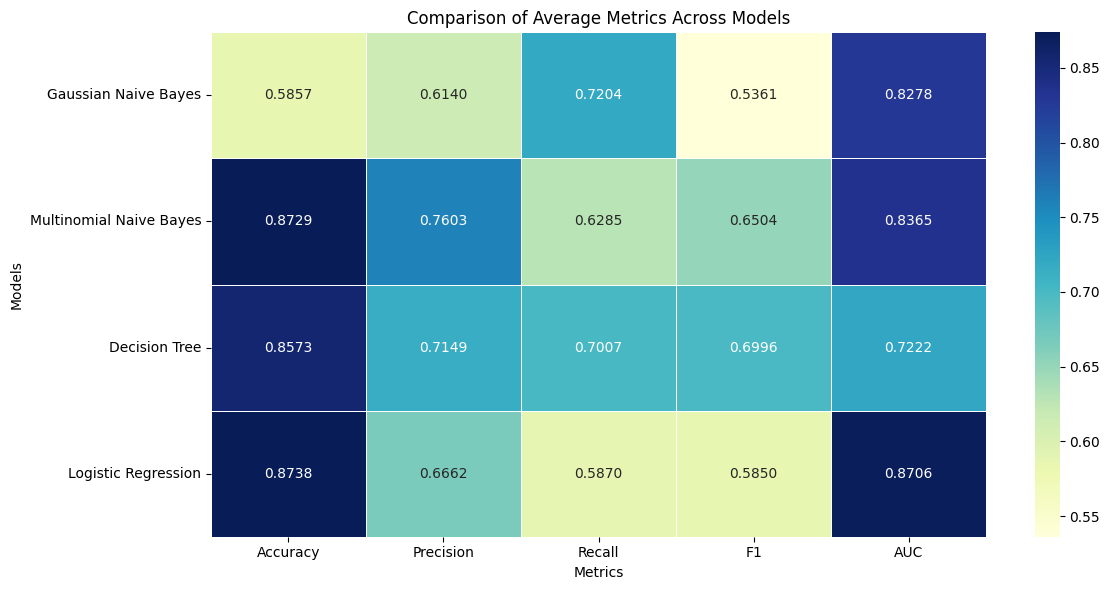

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns



# Results from all three models
metrics_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
models = ["Gaussian Naive Bayes", "Multinomial Naive Bayes", "Decision Tree", "Logistic Regression"]

average_metrics_plot = pd.DataFrame(
    [
        average_metrics_gaussian,   # Replace with the Gaussian Naive Bayes results
        average_metrics_multinomial,  # Replace with Multinomial Naive Bayes results
        average_metrics_decision_tree,  # Replace with Decision Tree results
        average_metrics_logistic_regression
    ],
    columns=metrics_names,
    index=models
)

# Heatmap visualization
plt.figure(figsize=(12, 6))
sns.heatmap(
    average_metrics_plot,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    linewidths=0.5
)
plt.title("Comparison of Average Metrics Across Models")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.tight_layout()
plt.show()
